In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.cheminformania.com/building-a-simple-smiles-based-qsar-model-with-lstm-cells-in-pytorch/

In [2]:
!pip install rdkit

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
df = pd.read_excel('Flu-IC50.xlsx').dropna(how='all', axis='columns')
df['S_leng'] = df['SMILES'].str.len()

In [5]:
df.head()

,Title,IC50,SMILES,S_leng
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,66
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,52
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,55
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,53
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,55


In [6]:
df['SMILES'].size

36377

36377 - 36217 - 36001 - 35825 - 35008

In [7]:
df = df[df.S_leng < 120]

In [8]:
# df['IC50'] = df['IC50'].apply(lambda x: x if x < 300 else 300)

In [9]:
df = df[df['IC50'] < 50]

In [10]:
df_w = df[['IC50', 'SMILES']]

In [11]:
df_w.describe()

,IC50
count,35552.000000
mean,4.394721
std,4.687567
min,0.000010
25%,1.655000
50%,3.574000
75%,5.694000
max,49.900000


## Анализ данныз

<Axes: xlabel='S_leng', ylabel='Count'>

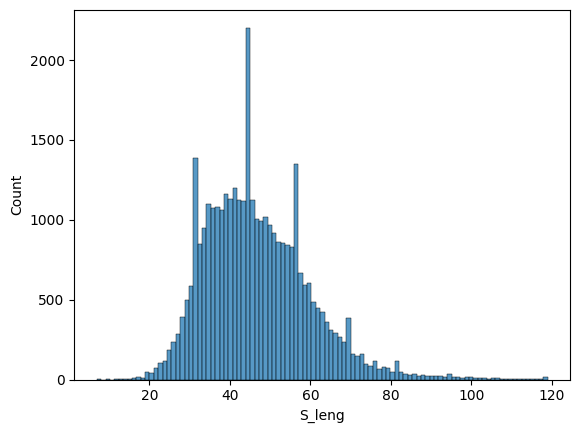

In [12]:
sns.histplot(df['S_leng'])

<Axes: xlabel='IC50', ylabel='Count'>

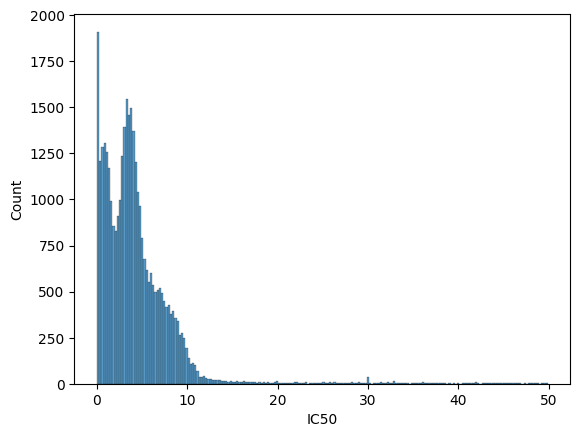

In [13]:
sns.histplot(df['IC50'])

## Векторайзер

In [14]:
PandasTools.AddMoleculeColumnToFrame(df_w,'SMILES','Molecule')
df_w[["SMILES","Molecule"]]

/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,SMILES,Molecule
0,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,<rdkit.Chem.rdchem.Mol object at 0x7e7d317482e0>
1,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,<rdkit.Chem.rdchem.Mol object at 0x7e7d31748040>
2,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,<rdkit.Chem.rdchem.Mol object at 0x7e7d317484a0>
3,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,<rdkit.Chem.rdchem.Mol object at 0x7e7d31748200>
4,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,<rdkit.Chem.rdchem.Mol object at 0x7e7d31748190>
...,...,...
35748,c1cccc(Cl)c1C(=O)Nc(ccc2)cc2CNCCc3c[nH]c(c34)c...,<rdkit.Chem.rdchem.Mol object at 0x7e7d2e654d60>
35749,COc1c(O)ccc(c1)[C@@H](N2)C(C(=O)OCC)=C(C)n(c=2...,<rdkit.Chem.rdchem.Mol object at 0x7e7d2e654dd0>
35750,c1ccccc1C(=O)/C=C(NC2)\C[C@@H](C=23)CN(C3=O)c4...,<rdkit.Chem.rdchem.Mol object at 0x7e7d2e654e40>
35751,o1cccc1\C=C\C(=O)Nc(c2)ccc(O)c2NC(=O)[C@@H](N)...,<rdkit.Chem.rdchem.Mol object at 0x7e7d2e654eb0>


In [15]:
!python -m pip install git+https://github.com/EBjerrum/molvecgen

  Cloning https://github.com/EBjerrum/molvecgen to /tmp/pip-req-build-5e2kkri1
  Running command git clone --filter=blob:none --quiet https://github.com/EBjerrum/molvecgen /tmp/pip-req-build-5e2kkri1
  Resolved https://github.com/EBjerrum/molvecgen to commit f81d5aade18bea60882f5845877f6283366bbe91
  Preparing metadata (setup.py) ... done


In [16]:
from molvecgen.vectorizers import SmilesVectorizer

In [17]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df_w.Molecule.values, )

In [18]:
print(smivec.charset)
smivec.dims

4aior+)ZC2/O]e17=F(#SBN.n[-P3I@5\lsH6c^$?


(120, 41)

In [19]:
print("Maximum allowed SMILES length %s"%smivec.maxlength)

Maximum allowed SMILES length 119


In [20]:
df_w['IC50']

0         0.000015
1         0.000016
2         0.000033
3         0.000032
4         0.000041
           ...    
35748    49.400000
35749    49.551000
35750    49.600000
35751    49.841000
35752    49.900000
Name: IC50, Length: 35552, dtype: float64

In [21]:
y = df_w['IC50'].values.reshape((-1,1))
X = df_w.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)
#Normalizing output using standard scaling
# scaler = MinMaxScaler()
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [22]:
y_train.shape

(21331, 1)

In [23]:
y_test.shape

(8888, 1)

In [24]:
y_validation.shape

(5333, 1)

In [25]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mols = self.molecules[idx]

        #The vectorizer was written to work with batches,
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

In [26]:
y_train

array([[-0.70472056],
       [-0.69406772],
       [-0.21873778],
       ...,
       [-0.18443562],
       [ 0.12513605],
       [-0.51957412]])

In [27]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[0]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8),
 array([-0.70472056]))

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_validation_t = smivec.transform(X_validation, canonical=False)
X_validation_t = torch.tensor(X_validation_t, device=device).float()
y_validation_t = torch.tensor(y_validation, device=device).float()
y_validation_t = torch.nan_to_num(y_validation_t, nan = torch.nanmean(y_validation_t))
X_validation_t.shape

cuda:0


torch.Size([5333, 120, 41])

In [29]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()

        length = dims[0]
        number_tokens = dims[1]


        self.lstm = nn.GRU(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False, dropout  = 0.2)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size//2) # Output layer
        self.activation2 = nn.ReLU() # Non-Linear ReLU Layer
        self.fc_out = nn.Linear(hidden_size//2, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Sigmoid()

    def forward(self, x):# Forward pass: stacking each layer together
        #out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out, h_n = self.lstm(x) #GRU network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.fc2(out) # Pass into the hidden layer
        out = self.activation2(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        # out = self.output(out)
        return out

epochs = 400
dims = smivec.dims
lstm_size = 32  # The size of the LSTM layer
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.4 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 64   # The mini_batch size during training
learning_rate = 0.005  # The initial learning rate for the optimizer

In [30]:
epochs = 50
dims = smivec.dims
lstm_size = 80 # The size of the LSTM layer
hidden_size = 32  # The size of the hidden non-linear layer
dropout_rate = 0.3 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 64   # The mini_batch size during training
learning_rate = 0.01  # The initial learning rate for the optimizer

In [31]:
model = Net(smivec, lstm_size, hidden_size, dropout_rate, output_size)
model.cuda()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Net(
  (lstm): GRU(41, 80, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=80, out_features=32, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (activation2): ReLU()
  (fc_out): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (output): Sigmoid()
)

In [32]:
pred = model.forward(X_validation_t[10:11])
pred

tensor([[[0.0397]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [33]:
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


In [34]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [35]:
model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, labels in train_loader:
        # Push numpy to CUDA tensors
        smiles = smiles.clone().detach().to(device).float()
        #print(smiles)
        labels = labels.clone().detach().to(device).float()
        labels = torch.nan_to_num(labels, nan = torch.nanmean(labels))
        #print(labels)
        #break
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass

        output = model(smiles)[0] #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss

        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights

        running_loss += loss.item()
    else:
        model.eval()
        validation_loss = torch.mean((y_validation_t - model(X_validation_t))**2).item()
        model.train()

        lr_scheduler.step(validation_loss)

        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%5 == 0:
            print("Epoch %i, Training loss: %0.5F Validation loss: %0.5F"%(e + 1, train_loss, validation_loss))

Epoch 5, Training loss: 0.96043 Validation loss: 1.05531
Epoch 10, Training loss: 0.96579 Validation loss: 1.05682
Epoch 15, Training loss: 0.94615 Validation loss: 1.04968
Epoch 20, Training loss: 0.96623 Validation loss: 1.07094
Epoch 25, Training loss: 0.95546 Validation loss: 1.06317
Epoch 30, Training loss: 0.96819 Validation loss: 1.06807
Epoch 35, Training loss: 0.96121 Validation loss: 1.07104
Epoch 40, Training loss: 0.96568 Validation loss: 1.08440
Epoch 45, Training loss: 0.96388 Validation loss: 1.07030
Epoch 50, Training loss: 0.95800 Validation loss: 1.06911


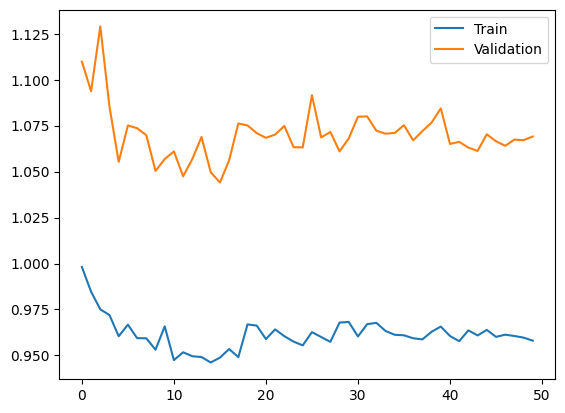

In [36]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
#plt.yscale('log')
plt.legend()

In [37]:
model.eval() #Swith to evaluation mode, where dropout is switched off
#y_pred_train = model(X_train_t)
y_pred_validation = model(X_validation_t)
#y_pred_test = model(X_test)

In [38]:
torch.mean((y_validation_t - y_pred_validation )**2).item()

1.0691108703613281

In [39]:
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t, device=device).float()
y_train_t = torch.tensor(y_train, device=device).float()
y_train_t = torch.nan_to_num(y_train_t, nan = torch.nanmean(y_train_t))
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()
y_test_t = torch.tensor(y_test, device=device).float()
y_test_t = torch.nan_to_num(y_test_t, nan = torch.nanmean(y_test_t))

In [40]:
torch.cuda.empty_cache()

In [41]:
# y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)
# train_rmse = torch.mean(( y_train_t - y_pred_train )**2).item()
train_rmse = 0
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.6F\tTest RMSE: %0.6F"%(train_rmse, test_rmse))

Train RMSE: 0.000000	Test RMSE: 0.861389


In [42]:
y_pred_test.shape

torch.Size([1, 8888, 1])

In [ ]:
len(set(float(x[0]) for x in y_pred_test[0]))

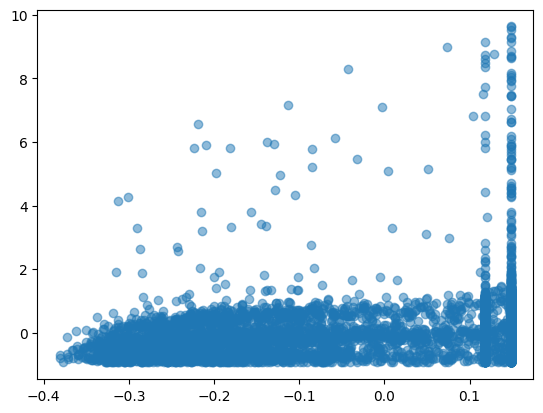

In [44]:
# plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_validation.tolist()).flatten(), np.array(y_validation_t.tolist()).flatten(), alpha=0.5)
# plt.plot([-0.2, 0.2], [-1.5,1.5], c="b")
#plt.xlim(-1,  1)
#plt.ylim(-0.1,  1)